In [9]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.stats import weibull_min

In [118]:
def generate_data(num_samples, num_points = 32):
    data = np.zeros((num_samples,2,num_points))
    coeffs = np.zeros(num_samples)
    for i in range(num_samples):
        coeff = np.random.uniform(0, 10, 1)
        # print(coeff)
        x = np.random.uniform(0, 10, num_points)
        # print("x",x)
        # Generate y values with noise
        noise = np.random.normal(0, 0.5*coeff, num_points)
        y = coeff * x + noise
        # print("y",y)
        data[i,:,:] = np.vstack((x,y))
        # print(np.vstack((x,y)))
        # print(coeff[0])
        coeffs[i] = coeff[0]
    return data,coeffs
    

# Generate some example data
example_data = generate_data(10)
# print(example_data)
train_data = generate_data(20000)
print(train_data[0].shape)
val_data = generate_data(100)

class TrendlineDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data[0].shape[0]

    def __getitem__(self, idx):
        slice_i = torch.tensor(np.take(self.data[0], indices=idx, axis=0), dtype=torch.float32)
        # print("slice", slice_i.shape)
        target = torch.tensor(np.array([self.data[1][idx]]),dtype=torch.float32)
        # print("target", target)
        return slice_i, target

train_dataset = TrendlineDataset(train_data)
print(train_dataset[0])
val_dataset = TrendlineDataset(val_data)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)
print(next(iter(train_loader))[0].shape)

(20000, 2, 32)
(tensor([[ 1.2127,  7.7612,  1.8490,  6.1082,  4.4012,  2.7607,  7.9435,  8.9716,
          0.7821,  0.4645,  7.6207,  6.2986,  4.8238,  6.7718,  5.9767,  3.9523,
          0.4361,  6.0034,  1.2172,  0.3201,  8.8786,  4.7112,  7.5891,  9.2605,
          0.4033,  3.5468,  4.1915,  8.4104,  8.7118,  6.6978,  4.5470,  1.7255],
        [ 5.0176, 49.8104, 13.5245, 43.0879, 24.0584, 13.7567, 48.3170, 51.8694,
          4.8784, 11.0050, 50.6432, 39.5990, 32.5681, 50.2328, 36.1181, 27.5704,
          5.0154, 35.7022,  8.1095,  0.6577, 62.2287, 34.1522, 48.4342, 56.5271,
         -0.1812, 22.5618, 29.7677, 51.5597, 49.6001, 38.2064, 31.1387,  7.3074]]), tensor([6.3837]))
torch.Size([32, 2, 32])


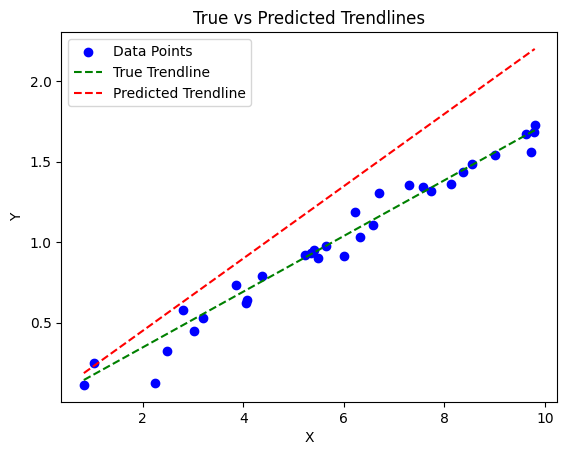

epoch 0, loss 0.2270296812057495
epoch 1, loss 0.30284813046455383
epoch 2, loss 0.09717827290296555
epoch 3, loss 0.10841907560825348
epoch 4, loss 0.11403102427721024
epoch 5, loss 0.14281916618347168
epoch 6, loss 0.08738228678703308
epoch 7, loss 0.09691465646028519
epoch 8, loss 0.11464531719684601
epoch 9, loss 0.06411885470151901


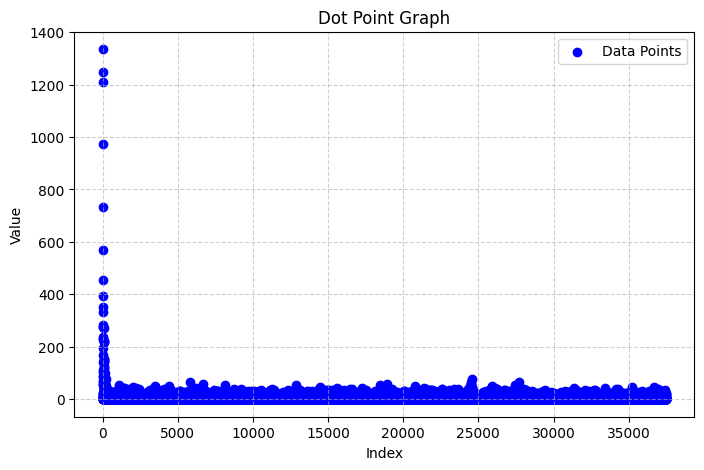

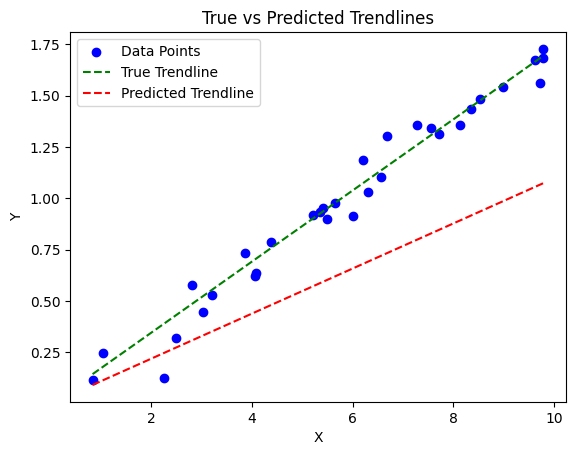

In [119]:
class linearRegression_guesser(torch.nn.Module):
    def __init__(self, num_points = 32):
        super(linearRegression_guesser, self).__init__()
        self.fc1 = nn.Linear(num_points*2, num_points*10)
        self.fc2 = nn.Linear(num_points*10, num_points*10)
        self.fc3 = nn.Linear(num_points*10, 1)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        
    def forward(self, input):
        flat = self.flatten(input)
        # print(flat.shape)
        out = self.relu(self.fc1(flat))
        out = self.relu(self.fc2(out))
        out = self.fc3(out)
        return out

def plot_dot_graph(values):
    """Plots an array of values as a dot point graph."""
    plt.figure(figsize=(8, 5))
    plt.scatter(range(len(values)), values, color='b', label='Data Points')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Dot Point Graph')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

def Train(model,train_loader, epochs,lr):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    gradients = []
    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            input,target = batch
            # print("input",input.shape)
            # print("target", target.shape)
            optimizer.zero_grad()
        
            # get output from the model, given the inputs
            outputs = model(input)
            # print("x",x.shape, x)
            # print("output",outputs.shape, outputs)
            # print("target",target.shape, target)
            # get loss for the predicted output
            loss = criterion(outputs, target)
            # print(loss)
            # get gradients w.r.t to parameters
            loss.backward()
            for name, param in model.named_parameters():
                if param.grad is not None:
                    gradients.append(param.grad.norm().item())
            optimizer.step()
    
        print('epoch {}, loss {}'.format(epoch, loss.item()))
    plot_dot_graph(gradients)    

def visualise_predictions(model, data,index = 0):
    data_points = np.take(data[0], indices=index, axis=0)
    # print("d_points",data_points.shape,data_points)
    x_values = data_points[0, :]  # Extract x-values
    y_values = data_points[1, :] 
    true_coeff = data[1][index]
    # print(true_coeff)

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient tracking for efficiency
        input = torch.tensor(np.expand_dims(data_points, axis=0), dtype=torch.float32)
        # print("input",input.shape,input)
        predicted_coeff = model(input).numpy()[0][0]
        # print(predicted_coeff)
    
    plt.scatter(x_values, y_values, label="Data Points", color="blue")

    # Define the range for trendlines
    x_line = np.linspace(min(x_values), max(x_values), 100)

    # True trendline: y = true_coeff * x
    y_true = true_coeff * x_line
    plt.plot(x_line, y_true, label="True Trendline", linestyle="dashed", color="green")

    # Predicted trendline: y = predicted_coeff * x
    y_pred = predicted_coeff * x_line
    plt.plot(x_line, y_pred, label="Predicted Trendline", linestyle="dashed", color="red")

    # Labels and legend
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.title("True vs Predicted Trendlines")

    # Show the plot
    plt.show()




learning_rate = 0.001
num_epochs = 10

model = linearRegression_guesser()
visualise_predictions(model,val_data)
Train(model,train_loader,num_epochs,learning_rate)
visualise_predictions(model,val_data,index=0)


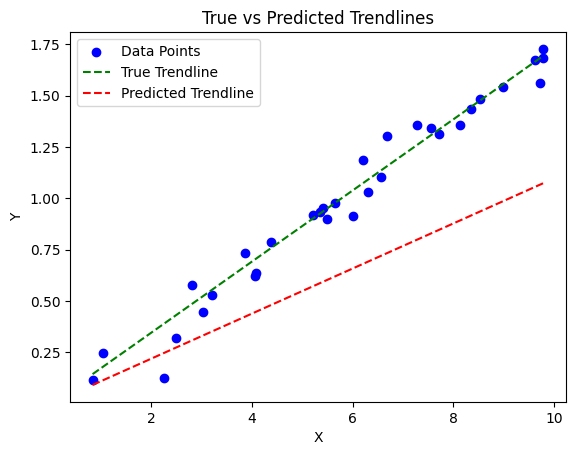

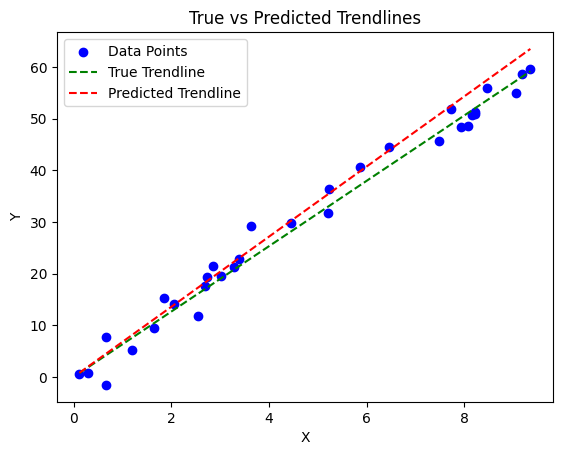

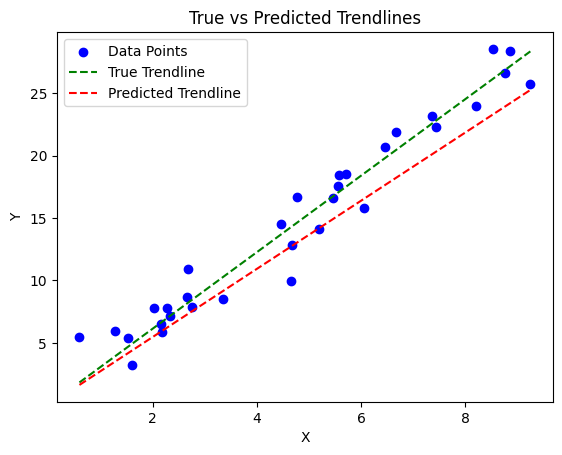

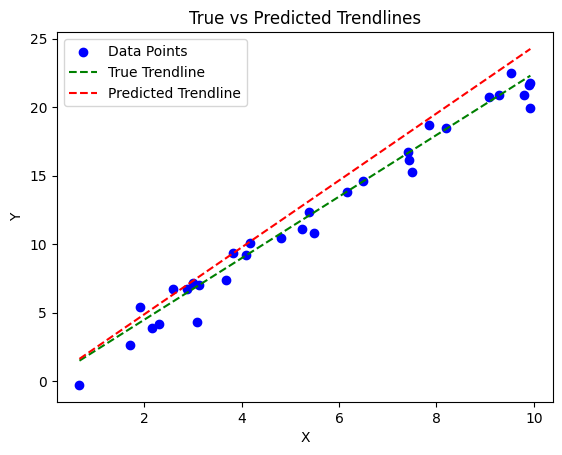

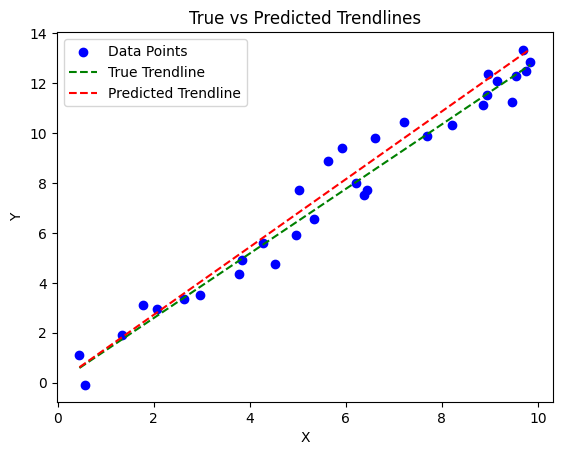

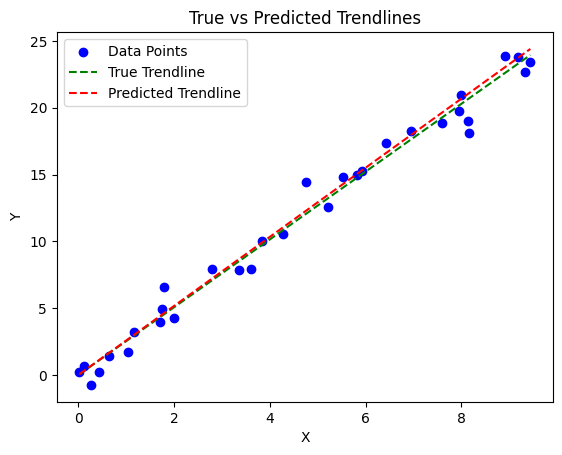

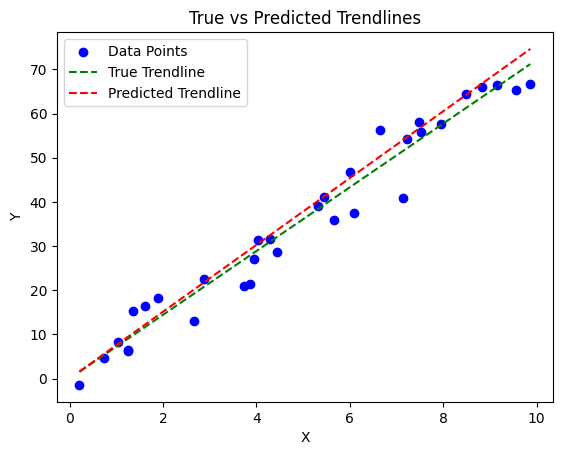

In [120]:
visualise_predictions(model,val_data)
visualise_predictions(model,val_data,index=1)
visualise_predictions(model,val_data,index=2)
visualise_predictions(model,val_data,index=3)
visualise_predictions(model,val_data,index=4)
visualise_predictions(model,val_data,index=5)
visualise_predictions(model,val_data,index=6)